In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/AML/ex2

Ablation_no_variance  VICReg_no_generation  VICReg_Run


In [ ]:
import sys
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms, datasets
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import plotly.graph_objects as go
from torchvision.models import resnet18
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from plotly.subplots import make_subplots
from torch.utils.data import Dataset
from sklearn.neighbors import NearestNeighbors
import itertools
import matplotlib.pyplot as plt
%pip install faiss-cpu
import faiss

In [ ]:
#models
class Encoder(nn.Module):
    def __init__(self, D=128, device='cuda'):
        super(Encoder, self).__init__()
        self.device = device
        self.D = D


        self.resnet = resnet18(pretrained=False).to(device)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=1)
        self.resnet.maxpool = nn.Identity()
        self.resnet.fc = nn.Linear(512, 512)
        self.fc = nn.Sequential(nn.BatchNorm1d(512), nn.ReLU(inplace=True), nn.Linear(512, self.D))

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        return x

    def encode(self, x):
        return self.forward(x)



class Projector(nn.Module):
    def __init__(self, D, proj_dim=512):
        super(Projector, self).__init__()
        self.D = D
        self.proj_dim = proj_dim
        self.model = nn.Sequential(nn.Linear(D, proj_dim),
                                   nn.BatchNorm1d(proj_dim),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(proj_dim, proj_dim),
                                   nn.BatchNorm1d(proj_dim),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(proj_dim, proj_dim)
                                   )

    def forward(self, x):
        return self.model(x)


# Datasets
class RepresentationDataset(Dataset):
    def __init__(self, representations, labels):
        self.representations = representations
        self.labels = labels

    def __len__(self):
        # Dataset length
        return len(self.representations)
    def get_represenatation(self,idx):
        return self.representations[idx]
    def __getitem__(self, idx):
        # Get item by index
        return self.representations[idx], self.labels[idx]

#OVERVIEW
VICReg is a self-supervised learning method designed to create robust representations from unlabeled image data. The key principle behind self-supervised learning is that even in the absence of labeled data, useful information can still be extracted from the input data. In the case of images, this often comes in the form of learning to recognize consistent patterns or structures in the image data, such as edges, shapes, and colors, or even higher-level concepts, given enough complexity.

VICReg operates by creating two views of the same image via random augmentations. Then it utilizes an encoder to extract representations from both views of the image. Then a projection head is applied to create a projection of each representation.

VICReg optimizes 3 different objectives using the projections z and z′ of each image in its batch. We name the 3 objectives as the Invariance, Variance and Covariance objectives:
.
#Invariance:
The algorithm seeks to make the projections of the two views as similar as possible. This makes sense as they are, after all, derived from the same base image. By ensuring that the model's representation is invariant to the chosen augmentations, it learns to ignore these superficial differences and instead focus on the underlying content of the image.
The Invariance Objective urges the encoder to remain invariant to the performed image augmentations, such as horizontal flipping. In such cases, the encoder should generate the same representation for the original image and its horizontally flipped counterpart. This objective is mathematically expressed by minimizing the Mean Squared Error (MSE) between the two projections (z and z'):
#####MSE loss:
    Linv(Z, Z') = (1 / |B|) * Σ MSE(zi, zi')
  Here, |B| is the batch size, Z and Z' are the projections of original and augmented images respectively, and the summation is over all instances in the batch.

.
#Variance:
VICReg aims to maximize the variance of each dimension in the projection. This means that it tries to make each dimension in the representation as informative as possible, rather than having redundant dimensions that all encode the same information. In a sense, this objective encourages the model to spread out its representation across the available dimensions.

The Variance Objective encourages the distinctness of each projection in the batch by ensuring that each dimension in the projection is significant. This is achieved by forcing the standard deviation of each dimension to surpass a predefined threshold using hinge loss. This objective can be formally represented as:
   
#####Hinge loss
    Lvar(Z) = (1 / d) * Σ Hinge(γ, σj) = (1 / d) * Σ max(0, γ - σj)
    σj = Var(z1, ..., z|B|) + ε

    Here, d is the dimensionality of the projections.
    γ and ε are hyperparameters (typically γ=1, ε=10^-4).
    σj represents the variance of each dimension of the projections.
    
    This objective is applied twice in each step, once for Z and once for Z'.
.
#Covariance:
Lastly, the algorithm aims to minimize the off-diagonal covariance between different dimensions in the projection. This encourages the model to learn representations where each dimension is independent from the others, preventing inter-dimensional dependencies and co-adaptations. This helps ensure that the learned representation is robust and generalizable.
The Covariance Objective is to de-correlate the variables of the projection to prevent the collapse of the representation to a limited number of dimensions. This objective minimizes the covariance between different dimensions in the projection. The covariance matrix is defined as follows:

#####Variance Matrix:

    C(Z) = (1 / |B|) * Σ (zi - z) * (zi - z)^T
    z = (1 / |B|) * Σ zi

#####Covariance objective:
    Lcov(Z) = (1 / d) * Σ [C(Z)]^2(i, j)

    Similar to the variance objective,
    the covariance objective is also applied to both Z and Z'.


.
# The full VICReg loss:
    LVICReg(Z, Z') = λ * Linv(Z, Z') + μ * [Lvar(Z) + Lvar(Z')] + ν * [Lcov(Z) + Lcov(Z')]
    
    Here, λ, μ, ν are hyperparameters controlling the weighting of the different losses.
    Both the variance and covariance objectives are performed on:
    the projection sets z1, ..., z|B|,
    the augmented set z1', ..., z'|B|'


# Algorithm 1: VICReg Training

1. **Input:** A dataset of images, I1, ..., IN

2. Initiate the training loop:

    ```python
    for ep in range(#Epochs):
        for B in range(Batches):
            Z = h(f(T(B))) # Z = projections from augmented batch B
            Z_prime = h(f(T(B))) # Z_prime = projections from same augmented batch B

            # Compute the VICReg Loss as per equation 6
            loss = λ * Linv(Z, Z_prime) + μ * (Lvar(Z) + Lvar(Z_prime)) + ν * (Lcov(Z) + Lcov(Z_prime))
        
            # Backward propagation

Here:
- `h` and `f` respectively represent the projection head and the encoder,
- `T` represents the image augmentation,
- `Linv`, `Lvar`, and `Lcov` correspond to the Invariance, Variance, and Covariance loss functions respectively,
- `λ`, `μ`, and `ν` are hyperparameters controlling the weighting of the different losses.


# Trainer

In [ ]:
# Trainer
#TODO: 1) Refract Trainer class. (Incoporate functions in curtomDataLoader/losses/)
#      2) Extract loss fucntions
class Trainer(object):
    def __init__(self,path,
                 train_loader,test_loader, epochs=10, device='cuda',
                 batch_size=256,encoder_dim = 128,scheduler=None,train_transform=None,
                 test_transform=None):
        self.path= path
        self.encoder = Encoder(D=encoder_dim).to(device)  # Encoder
        self.projector = Projector(self.encoder.D, proj_dim=512).to(device)  # Projection head
        self.T = self.transform_batch  # socrastic augmentations on batch
        self.linear_classifier = None
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.representations = []
        self.representations_labels = []
        self.linear_probing_acc = 0
        self.neighboring_indices = []


        self.params = list(self.encoder.parameters()) + list(self.projector.parameters())
        self.optimizer = torch.optim.Adam(self.params, lr=3e-4, betas=(0.9, 0.999), weight_decay=1e-6)
        self.scheduler = scheduler

        # Tranformation functions
        self.train_transform = train_transform
        self.test_transform = test_transform

        # Hyperparameters for loss functions
        self.lambd = 25.
        self.eps = 1e-4
        self.nu = 1.

        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device

        # losses: A dictionary to store all three types of losses
        self.train_losses = {'var': [], 'inv': [], 'cov': [], 'total_vic': []}
        self.validation_losses = {'var': [], 'inv': [], 'cov': [], 'total_vic': []}

    def transform_batch(self, data, train=True):
        """
        Transform the data using the appropriate transformations for training or testing.

        Returns:
            torch.Tensor: The transformed data.
        """
        transform = self.train_transform if train else self.test_transform
        data_view = torch.stack(list(map(transform, data)))
        return data_view


    def save_models(self,encoder=True,projector=True,losses=True,linear_classifier = False):
        if encoder:

            torch.save(self.encoder.state_dict(), self.path + '/encoder.pth')
        if projector:
            torch.save(self.projector.state_dict(), self.path + '/projector.pth')
        if losses:
            torch.save(self.train_losses, self.path + '/train_losses.pt')
            torch.save(self.validation_losses, self.path + '/validation_losses.pt')
        if linear_classifier:
            torch.save(self.linear_classifier,self.path + '/linear_classifier.pth')




    def load_models(self,encoder=True,projector=True,losses=True,linear_classifier= False):
        if encoder:
            self.encoder.load_state_dict(torch.load(self.path + '/encoder.pth'))
        if projector:
            self.projector.load_state_dict(torch.load(self.path + '/projector.pth'))
        if losses:
            self.train_losses = torch.load(self.path + '/train_losses.pt')
            self.validation_losses = torch.load(self.path + '/validation_losses.pt')
        if linear_classifier:
            self.linear_classifier = torch.load(self.path + '/linear_classifier.pth')


    def eval_VICReg(self):
      self.encoder.eval()
      self.projector.eval()
      for (data, labels) in self.test_loader:
        z1 = self.projector(self.encoder(self.T(data).to(self.device)))  # Z1 = projections represntation 1
        z2 = self.projector(self.encoder(self.T(data).to(self.device)))  # Z2 = projections from same augmented batch B

        # VICReg Loss
        inv_loss,var_loss,cov_loss,vic_loss = self.loss_VICReg(z1, z2)

        # Update losses dictionary
        self.validation_losses['var'].append(var_loss.item())
        self.validation_losses['inv'].append(inv_loss.item())
        self.validation_losses['cov'].append(cov_loss.item())
        self.validation_losses['total_vic'].append(vic_loss.item())



    def train_VICReg(self,mu=25.):
        for epoch in range(self.epochs):
            self.encoder.train()
            self.projector.train()
            for b_idx,(data, labels) in enumerate(self.train_loader):
                # Transform image
                z1 = self.projector(self.encoder((self.T(data).to(self.device))))
                z2 = self.projector(self.encoder((self.T(data).to(self.device))))
                # VICReg Loss
                inv_loss,var_loss,cov_loss,vic_loss = self.loss_VICReg(z1, z2,mu=mu)

                # Backward on projector and encoder
                vic_loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                # Update losses dictionary
                self.train_losses['var'].append(var_loss.item())
                self.train_losses['inv'].append(inv_loss.item())
                self.train_losses['cov'].append(cov_loss.item())
                self.train_losses['total_vic'].append(vic_loss.item())

                # printing:
                if b_idx % 100 == 0:
                    print("losses:\n","var_loss",var_loss.item(),inv_loss.item(),"cov_loss:",cov_loss.item())
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                            epoch, b_idx * len(data), len(self.train_loader.dataset),
                            100. * b_idx / len(self.train_loader), vic_loss.item()))
            self.eval_VICReg()

    def train_VICReg_no_generation(self,mu=25.):
            self.encoder.train()
            self.projector.train()
            self.get_nearest_neighbors(3,self.representations)

            # run for 1 epoch
            for b_idx,(data, labels) in enumerate(self.train_loader):
                batch_size = data.shape[0]

                # get nearest neigbor
                neighbor_indices = self.neighboring_indices[b_idx*batch_size:(b_idx+1)*batch_size]
                nearest_nbrs_idx = [np.random.choice(indices) for indices in neighbor_indices]
                nearest_nbrs_repr = torch.tensor(self.representations[nearest_nbrs_idx],device=self.device,dtype = torch.float32)


                z1 = self.projector(nearest_nbrs_repr)
                z2 = self.projector(self.encoder((data.to(self.device))))


                # VICReg Loss
                inv_loss,var_loss,cov_loss,vic_loss = self.loss_VICReg(z1, z2,mu=mu)

                # Backward on projector and encoder
                vic_loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

                # Update losses dictionary
                self.train_losses['var'].append(var_loss.item())
                self.train_losses['inv'].append(inv_loss.item())
                self.train_losses['cov'].append(cov_loss.item())
                self.train_losses['total_vic'].append(vic_loss.item())



    def get_nearest_neighbors(self, number_of_neighbors,representations):

        nbrs = NearestNeighbors(n_neighbors=number_of_neighbors+1, algorithm='auto').fit(representations)
        distances, indices = nbrs.kneighbors(representations)
        self.neighboring_indices = indices[:,1:]  # We start from 1 to exclude self

    # Direct implementation
    # for repr in self.representations:
        #     # Compute Euclidean distances to all other representations
        #     distances = list(map(lambda x: np.linalg.norm(repr - x), self.representations))
        #     # Get indices of nearest neighbors
        #     nearest_neighbors = np.argsort(distances)[1:number_of_neighbors+1]  # We start from 1 to exclude self
        #     self.neighboring_indices.append(nearest_neighbors)


    def get_representations(self,train=True):
        """
        Extracts representations and corresponding labels from the encoder for the given dataset.

        Parameters:
            train (bool): If True: extracts representations from the training dataset.
                          Else testing dataset


        Updates the 'representations' and 'representations_labels'
        of shape (num_samples, representation_dim) and (num_samples,)

        """
        self.representations = []
        self.representations_labels = []
        self.encoder.eval()

        dataloader = self.train_loader if train else self.test_loader
        for b_idx, (data, labels) in enumerate(dataloader):
            # get image representation
            z1 = self.encoder(data.to(self.device))
            self.representations.append(z1.detach().cpu().numpy())
            self.representations_labels.append(labels.detach().cpu().numpy())
        self.representations = np.concatenate(self.representations, axis=0)
        self.representations_labels = np.concatenate(self.representations_labels, axis=0)

    # Losses:

    def Linv(self,z1, z2):
        # Invariance Loss: MSE between projections Z1 and Z2
        return F.mse_loss(z1, z2)

    def Lvar(self,z,thresh=1, eps=1e-4):
        # Variance Hinge loss on projections batch with predefined threshold
        std = torch.sqrt(z.var(dim=0) + eps)  # variance of dimensions of each projection#TODO: check dim
        hinge_loss = torch.clamp(thresh - std, min=0)  # hinge loss for each dimension
        return torch.mean(hinge_loss)  # average hinge loss across all projections (invarient to batch size)


    def Lcov(self,z):
        # Your Covariance Loss implementation goes here
        N, D = z.shape
        z_ = z - z.mean(dim=0)
        cov_z = ((z_.T @ z_) / (N - 1)).square()
        return (cov_z.sum() - cov_z.diagonal().sum()) / D # TODO: is this why this loss crahsed? (added "/D") -> YES

    def loss_VICReg(self,z1, z2, lambd = 25., mu = 25., nu=1.): #TODO: q4-->mu=0????
        inv_loss = self.Linv(z1, z2)
        var_loss = (self.Lvar(z1) + self.Lvar(z2))
        cov_loss= (self.Lcov(z1) + self.Lcov(z2))
        vic_loss = (inv_loss * lambd) + (var_loss * mu) + (cov_loss * nu)
        return inv_loss,var_loss,cov_loss,vic_loss


    # Linear Probing
    def linear_probing(self,embedding_size, num_epochs = 10, num_of_classes = 10):
        # function assumes self.get_representations() was called

        # Training linear classifier
        self.encoder.eval()
        classifier = nn.Linear(self.encoder.D, num_of_classes).to(device).train()
        model = nn.Sequential(self.encoder,classifier)
        # optimize only classifier
        optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
        criterion = nn.CrossEntropyLoss()

        # Train the classifier
        for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(self.train_loader):
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            print("epoch number:" + str(epoch))
        self.linear_classifier = classifier
        self.save_models(encoder=False,projector=False,losses=False,linear_classifier= True)

        # Test the classifier and record accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        self.linear_probing_acc = accuracy
        print(f"Test Accuracy of the model on the test images: {accuracy} %")


    def plot_loss(self):
        num_batches_per_epoch_train = len(self.train_loader)
        num_batches_per_epoch_val = len(self.test_loader)
        num_epochs = len(self.train_losses['var']) // num_batches_per_epoch_train

        for loss_name in ['var', 'inv', 'cov']:
            fig = go.Figure()

            # Average train losses over each epoch
            # train_loss_averaged = [np.mean(self.train_losses[loss_name][i*num_batches_per_epoch_train:(i+1)*num_batches_per_epoch_train]) for i in range(num_epochs)]

            # Average validation losses over each epoch
            # val_loss_averaged = [np.mean(self.validation_losses[loss_name][i*num_batches_per_epoch_val:(i+1)*num_batches_per_epoch_val]) for i in range(num_epochs)]

            # Add traces
            fig.add_trace(go.Scatter(y=self.train_losses[loss_name], mode='lines', name='train'))
            # fig.add_trace(go.Scatter(y=val_loss_averaged, mode='lines', name='validation'))

            # Layout
            fig.update_layout(title=f'{loss_name} Loss over Time',
                              xaxis_title='Epochs',
                              yaxis_title='Loss')

            fig.show()


    def plot_PCA_and_SNE(self,pca_result,tsne_result):
        # Define the colorscale mapping
        color_map = ['blue', 'black','green', 'red', 'cyan', 'magenta', 'yellow','grey', 'brown', 'white']  # Add more if you have more classes

        # Create PCA scatter plot
        trace_pca = go.Scatter(
            x=pca_result[:, 0],
            y=pca_result[:, 1],
            mode='markers',
            marker=dict(
                size=6,
                color=[color_map[int(i)] for i in self.representations_labels],  # assign color based on labels
                opacity=0.8),
                showlegend=False

            )


        # Create a subplot with 1 row and 2 columns
        fig = make_subplots(rows=1, cols=2)

        # Add PCA scatter plot to the first column
        fig.add_trace(trace_pca, row=1, col=1)

        # Create t-SNE scatter plot
        trace_tsne = go.Scatter(
            x=tsne_result[:, 0],
            y=tsne_result[:, 1],
            mode='markers',
            marker=dict(
                size=6,
                color=[color_map[int(i)] for i in self.representations_labels],  # assign color based on labels
                opacity=0.8),
                showlegend=False
            )


        # Add t-SNE scatter plot to the second column
        fig.add_trace(trace_tsne, row=1, col=2)


        # Update xaxis and yaxis properties for the PCA plot
        fig.update_xaxes(title_text="PCA 1", row=1, col=1)
        fig.update_yaxes(title_text="PCA 2", row=1, col=1)

        # Update xaxis and yaxis properties for the t-SNE plot
        fig.update_xaxes(title_text="t-SNE 1", row=1, col=2)
        fig.update_yaxes(title_text="t-SNE 2", row=1, col=2)


      # Now, add dummy scatter plots for the legend
        for i, color in enumerate(color_map):
            fig.add_trace(go.Scatter(
                x=[None],  # No data for x and y
                y=[None],
                mode='markers',
                marker=dict(
                    size=6,
                    color=color,
                ),
                name=f"Class {i}",  # The name that will appear in the legend
            ))

        # Update the layout
        fig.update_layout(height=600, width=1200, title_text="PCA vs t-SNE")


        # Show the plot
        fig.show()


    def retrieval_evaluation(self):

        # Extract representations
        self.get_representations() # Also sets the encoder to evaluation mode


        # Select 10 random images from different classes
        images_from_each_class, indices_from_each_class = self.get_image_from_each_class()
        print(indices_from_each_class)

        # Get the representations of these images
        random_image_reprs = self.representations[indices_from_each_class]

        # 2. Build the FAISS index
        dimension = self.representations.shape[1]  # dimension of the vector
        index = faiss.IndexFlatL2(dimension)
        index.add(self.representations.astype('float32'))  # FAISS uses float32

        # 3. Run the nearest neighbor search with 6 nebrs

        _, indices = index.search(random_image_reprs.astype('float32'), self.representations.shape[0])
        indices = torch.tensor(indices)

        # Get the 5 nearest and furthest neighbors for each image
        for i  in range(len(random_image_reprs)):
            nearest_indices = indices[i, 1:6]  # We start from 1 to exclude self
            furthest_indices = indices[i, -5:]

            nearest_images = [self.get_image_from_index(idx) for idx in nearest_indices]
            furthest_images = [self.get_image_from_index(idx) for idx in furthest_indices]

            # Plot the original image along with the nearest and furthest images
            self.plot_images([images_from_each_class[i]] + nearest_images + furthest_images)


    def get_image_from_each_class(self,train=True):
        classes = list(range(10))  # Assuming you have 10 classes
        images_from_each_class = [None]*10
        indices_from_each_class = [None]*10
        dataloader =  self.train_loader if train else self.test_loader

        idx = 0  # Starting index
        for batch in dataloader:
            images, labels = batch
            for c in classes:
                if c in labels:
                    class_idx = (labels == c).nonzero(as_tuple=True)[0][0]
                    images_from_each_class[c] = images[class_idx].detach().cpu()
                    indices_from_each_class[c] = idx + class_idx.item()
                    classes.remove(c)
                if not classes:  # if all classes are found
                    break
            if not classes:
                break

            idx += len(images)  # Update the cumulative index

        return images_from_each_class, indices_from_each_class

    def get_image_from_index(self, idx,train=True): #TODO: refract to custom dataset with specified (__getitem__ for cleaner indexing)
        cumulative_idx = 0
        dataloader =  self.train_loader if train else self.test_loader

        for batch in dataloader:
            images, labels = batch
            if cumulative_idx + len(images) > idx:
                return images[idx - cumulative_idx].cpu().detach() #TODO: checks data stored in RAM and not GPU
            cumulative_idx += len(images)
        raise IndexError('Index out of range of dataset')



    def plot_images(self,images):
        """
        Takes a list of images and plots them in a row.
        """
        fig, axes = plt.subplots(1, len(images), figsize=(len(images), 1))

        for ax, img in zip(axes, images):
            img = img.permute(1,2,0) # Transpose
            ax.imshow(img)
            ax.axis('off')

        plt.tight_layout()
        plt.show()

##DATA


In [ ]:
# Load Data NOTE: Set train_loader shuffle= False for Q8
transform = transforms.Compose([transforms.ToTensor()])
train_set = CIFAR10(root='./data', train=True,download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=256,shuffle=True, num_workers=2)
test_set = CIFAR10(root='./data', train=False,download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=256,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


#1 Training.
Train VICReg on the CIFAR10 dataset. Plot the values of each of the 3 objectives (in separate figures) as a function of the training batches. In your figures also include the loss terms values on the test set, computed once every epoch.

Note both Encoder and Projector are trained simultaneously. The idea is that the encoder learns to extract useful, invariant features from the raw input, and the projector learns to arrange these features in a way that's beneficial for the downstream task (e.g., image classification).

In [ ]:
# Augmentations:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

In [ ]:
# # Train model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# trainer = Trainer(train_loader,test_loader, epochs=30, device=device,
#                  batch_size=256,encoder_dim=128,train_transform=train_transform,
#                  test_transform=test_transform,scheduler=None)
# trainer.train_VICReg()
# trainer.save_models()

# loading trainer
path = '/content/drive/MyDrive/AML/ex2/VICReg_Run'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainer = Trainer(path,train_loader,test_loader, epochs=30, device=device,
                 batch_size=256,encoder_dim=128,train_transform=train_transform,
                 test_transform=test_transform,scheduler=None)

trainer.load_models()


NameError: ignored

#2 PCA vs. T-SNE Visualizations.
 Compute the representations of each test image using your trained encoder. Map (using the sklearn library) the representation to a 2D space using: (i) PCA (ii) T-SNE.

 Plot the T-SNE and the PCA 2D representations, colored by their classes. Look at both visualizations (PCA vs. T-SNE)

 - Which one seems more effective for visualizations to you?
 - Look at the T-SNE visualization. Did VICReg managed to capture the class information accurately?
 - Which classes seem entangled to you? Explain your answer in detail.


In [ ]:

trainer.get_representations(train=False)
representations = trainer.representations
# Perform PCA and Perform T-SNE
pca = PCA(n_components=2)
pca_result = pca.fit_transform(representations)
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(representations)
# Plot
# trainer.plot_PCA_and_SNE(pca_result,tsne_result)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



In [ ]:
trainer.plot_PCA_and_SNE(pca_result,tsne_result)


## Answers:
####Effectiveness of PCA vs t-SNE:
 PCA is a linear dimension reduction technique that seeks to maximize variance and preserves large pairwise distances. In contrast, t-SNE is a non-linear technique which preserves small pairwise distances or local similarities, which might make clusters of similar data points more discernible.

####VICReg performance:
 If the t-SNE visualization shows that data points (images) from the same class tend to group together in clusters, this suggests that the VICReg has indeed captured class information effectively.

####Entangled classes:
 If you see that points from different classes are mixed together in the t-SNE plot (i.e., they do not form distinct clusters), it might suggest that these classes are "entangled", meaning that the learned representations for these classes are not clearly separable. This could be because the classes are inherently similar, or it could suggest that the model has trouble distinguishing between these classes.

#3 Linear Probing.
Perform a linear probing (single FC layer) to the encoder’s representation. Train this classifier on the representations of the CIFAR10 train set. Remember to freeze the encoder, i.e. do not update it. Compute the probing’s accuracy on the test set. What is the accuracy you reach with your classifier?
Note: classifier accuracy should be at least 60% on the test set.

In [ ]:
trainer.get_representations(train=True)
representation_dataset = RepresentationDataset(trainer.representations, trainer.representations_labels)
representation_dataloader = DataLoader(representation_dataset, batch_size=64, shuffle=True)
trainer.linear_probing(embedding_size = 128,num_epochs=10,num_of_classes=10)

epoch number:0
epoch number:1
epoch number:2
epoch number:3
epoch number:4
epoch number:5
epoch number:6
epoch number:7
epoch number:8
epoch number:9
Test Accuracy of the model on the test images: 72.5 %


In [ ]:
trainer.save_models(linear_classifier = True)

#4 Ablation1 - No Variance Term.
 Modify the optimized objective, by removing the variance objective term (μ = 0.). Using the representations from the modified encoder, perform the same PCA visualization from Q2, and the linear probing from Q3 (and include them in your report). Is the new accuracy better or worse? Can you see anything different in the representations visualization? Try to explain the difference in the accuracy using the visualizations.

In [ ]:
## Train model with mu=0
path = '/content/drive/MyDrive/AML/ex2/Ablation_no_variance'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainer = Trainer(path,train_loader,test_loader, epochs=15, device=device,
                 batch_size=256,encoder_dim=128,train_transform=train_transform,
                 test_transform=test_transform,scheduler=None)
# trainer.train_VICReg(mu=0)
# trainer.save_models(linear_classifier=True)
trainer.load_models(path,linear_classifier=True)

In [ ]:
trainer.get_representations(train=True)

representations = trainer.representations
## Perform PCA and Perform T-SNE
pca = PCA(n_components=2)
pca_result = pca.fit_transform(representations)
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(representations)
# Plot
trainer.plot_PCA_and_SNE(pca_result,tsne_result)

## Linear probing
representation_dataset = RepresentationDataset(torch.tensor(trainer.representations), torch.tensor(trainer.representations_labels))
representation_dataloader = DataLoader(representation_dataset, batch_size=64, shuffle=True)
trainer.linear_probing(embedding_size = 128,num_epochs=10,num_of_classes=10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



KeyboardInterrupt: ignored

#5 Ablation2 - No Amortization.
 We would like to ablate VICReg by only replacing its amortized encoder with Latent Optimization (LO). This means we want to keep the different views of each sample to be generated. Un- fortunately, this will not work, without additional components. Without performing any experiment, please explain in detail: what is the problem in this setting? What essential part is missing? Offer any correction that keeps the LO to this setting, which will allow it to work properly. Explain why your new setting should work, what added value your correction has?

#6 Ablation3 - NoGeneratedNeighbors.
Now,wewouldliketoablateVICRegbyonlyremovingthegenerated neighbors, using neighbors from the data itself: First, compute the representations of your original VICReg, on all of the training set. In each step of training and for each image in the batch, use these representations to find the top 3 nearest neighbors, and randomly select 1 of them. Use the original image and this neighbor of it as your 2 views

for the VICReg algorithm. 2 Practical Tips: (i) We find that training this algorithm for only a single epoch is more beneficial. (ii) We recommend you to compute the neighboring indices of each image in advance, and delete the original VICReg model from your (GPU) memory. This will save both run time and GPU space.
Compute the linear probing accuracy, and report it. Is the accuracy different from the original linear probing from Q3?
• If no, explain why do you think this change had no effect (what compensates the things that are missing?). • If yes, explain what added value do you think the generated neighbors adds to the algorithm.


In [ ]:
# Init Trainer
path = '/content/drive/MyDrive/AML/ex2/VICReg_no_generation'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainer = Trainer(path,train_loader,test_loader, epochs=30, device=device,
                 batch_size=256,encoder_dim=128,train_transform=train_transform,
                 test_transform=test_transform,scheduler=None)
trainer.representations = torch.load('/content/drive/MyDrive/AML/ex2/VICReg_Run/train_representations.pt')

# Train model
trainer.train_VICReg_no_generation()
# trainer.save_models()

# loading trainer
# trainer = Trainer(path,train_loader,test_loader, epochs=30, device=device,
#                  batch_size=256,encoder_dim=128,train_transform=train_transform,
#                  test_transform=test_transform,scheduler=None)

# trainer.load_models()


# Linear probing
trainer.get_representations()
representation_dataset = RepresentationDataset(torch.tensor(trainer.representations), torch.tensor(trainer.representations_labels))
representation_dataloader = DataLoader(representation_dataset, batch_size=64, shuffle=True)
trainer.linear_probing(embedding_size = 128,num_epochs=10,num_of_classes=10)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.



#7 Ablation4 - Laplacian Eigenmaps.
 After removing the generated neighbors and the amortization alone (well... we wanted to), we would like to remove them both at once. To do so, we will perform Laplacian Eigenmaps [5] representation learning on the training data of CIFAR10. Since this algorithm is difficult to run, we ran it for you on 10K images (due to runtime limitations) and give you the T-SNE plotting of these representations in Fig. 2 3. Compare this to VICReg’s T-SNE plot from Q2. Based on this visual and linear probing comparison, which method (VICReg vs. Laplacian Eigenmaps) seems more effective for downstream object classification? Explain your answer in detail, including what do you think makes one algorithm to be more successful.

#8 Retrieval Evaluation.
 Now that we slowly "pealed" VICReg back to the laplacian eigenmaps algorithm, we wish to evaluate it qualitatively. For the methods Q1 (VICReg) and Q6 (No Generated Neighbors) perform a qualitative retrieval evaluation. That means:
• Select 10 random images from the training set, one from each class.
• For each selected image,usetherepresentationsofeachoftheevaluatedmethods,tofindits5nearestneighbors in the dataset.
• Plot the images together with their neighbors.
• Using the same images, perform the same visualization for the 5 most distant images in the dataset.
Using this visualization, explain what attributes each method attends to. What are the differences you see between the different methods? Which one excels at keeping close images together? Which one excels at keeping distant images far apart? Explain the differences between the methods in detail, as seen by this visualization. You may select more than 1 image for a specific class if you wish to get a better understanding (Although it is not mandatory).


**VIGReg Method**

In [ ]:
path = '/content/drive/MyDrive/AML/ex2/VICReg_Run'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainer = Trainer(path,train_loader,test_loader, epochs=30, device=device,
                 batch_size=256,encoder_dim=128,train_transform=train_transform,
                 test_transform=test_transform,scheduler=None)
trainer.load_models()
trainer.retrieval_evaluation()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


**No Generated Neighbors Method**

[29, 257, 6, 517, 3, 260, 0, 771, 8, 265]


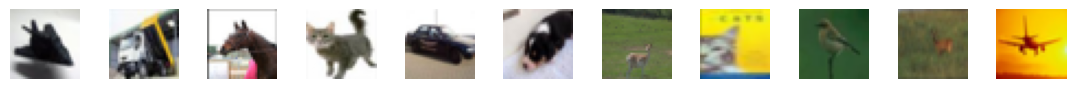

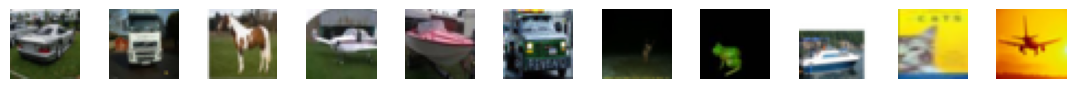

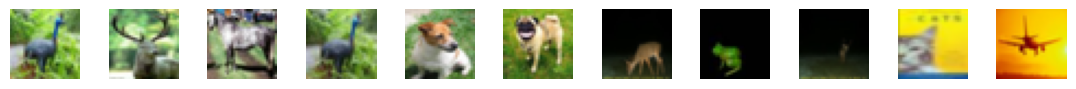

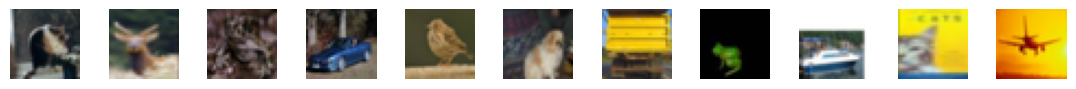

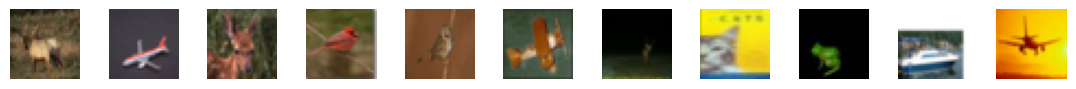

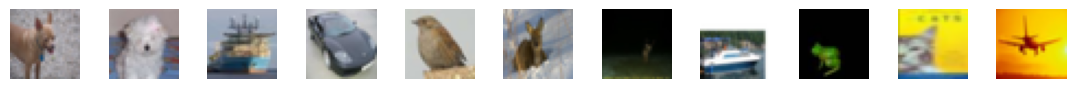

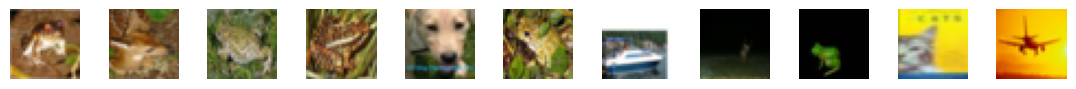

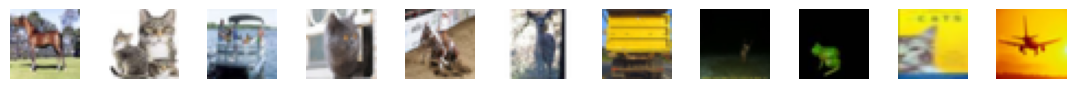

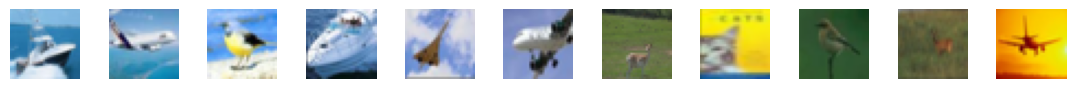

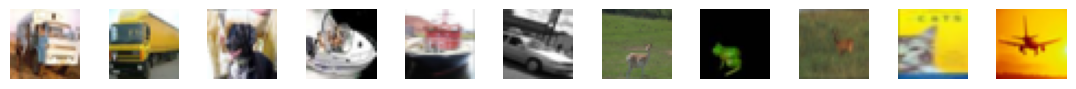

In [ ]:
path = '/content/drive/MyDrive/AML/ex2/VICReg_no_generation'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainer = Trainer(path,train_loader,test_loader, epochs=30, device=device,
                 batch_size=256,encoder_dim=128,train_transform=train_transform,
                 test_transform=test_transform,scheduler=None)
trainer.load_models()
trainer.retrieval_evaluation()

##Anomally Detection

**Setting and Dataset Definition**

  For evaluating anomaly detection, we need define our normal data to be the CIFAR10 (In such, the experiments should be performed using your already trained algorithms). Our anomalies will be images from the MNIST dataset. This means the training data is the CIFAR10 training data, but the test data is the combination of the CIFAR10 test data and the MNIST test data. All images from CIFAR10 are labelled 0 (normal), and all images from the MNIST dataset are labelled 1 (anomalies).

In [ ]:
class TestDataset(Dataset):
    def __init__(self):
        # Transforms for CIFAR-10
        transform_cifar = transforms.Compose([transforms.ToTensor()])

        # Transforms for MNIST
        transform_mnist = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor()
        ])

        # Load the MNIST test dataset
        mnist_testset = datasets.MNIST(root='./', train=False, download=True, transform=transform_mnist)

        self.mnist_data = np.array([img.numpy() for img, _ in mnist_testset])
        self.mnist_labels = np.ones(len(mnist_testset))

        # Load the CIFAR-10 test dataset
        cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
        self.cifar_data = np.array(cifar_testset.data)
        self.cifar_data = self.cifar_data.reshape(self.mnist_data.shape)
        self.cifar_labels = np.zeros(len(cifar_testset))

        # Concatenate the data and labels
        self.data = np.concatenate((self.cifar_data, self.mnist_data), axis=0)
        self.labels = np.concatenate((self.cifar_labels, self.mnist_labels),axis=0)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    def get_x_y(self):
        return self.data, self.labels


In [ ]:

# Dataset for anaomaly detection:
transform = transforms.Compose([transforms.ToTensor()])
testset = TestDataset()
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test_loader = DataLoader(testset,batch_size=256,shuffle=False,num_workers=4) # see if i can reduce number of workers even if trainer on 4
train_loader = DataLoader(trainset, batch_size=256,shuffle=False, num_workers=4)# removed suffle for train

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Trainer for VICReg and NGN methods
path_vic = '/content/drive/MyDrive/AML/ex2/VICReg_Run'
trainer_vic = Trainer(path_vic,train_loader,test_loader, epochs=30, device=device,
                 batch_size=256,encoder_dim=128)
path_ngn = '/content/drive/MyDrive/AML/ex2/VICReg_no_generation'
trainer_ngn = Trainer(path_ngn,train_loader,test_loader, epochs=30, device=device,
                 batch_size=256,encoder_dim=128)
# Load models
trainer_vic.load_models()
trainer_ngn.load_models()






Files already downloaded and verified
(10000, 32, 32, 3)
(10000, 3, 32, 32)
(10000, 3, 32, 32) minst_data: (10000, 3, 32, 32)
(10000,) minst_labels: (10000,)
DATA : (20000, 3, 32, 32)
LABELS : (20000,)
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


**Anomaly Detection**

 Using the CIFAR10 training data as reference for normal data, compute the kNN density estimation for all the (CIFAR10 + MNIST) test set representations. Do this for both (i) VICReg (ii) VICReg without generated neighbors (Sec. 3, Q6) . Use k = 2.

In [ ]:
def compute_density(trainer,k=2): # k: # of neighbors
    # train representations
    trainer.get_representations(train=True)
    train_repr = trainer.representations.copy() # shallow copy is insufficient ?
    # train_repr = np.array([repr.copy() for repr in trainer.representations])
    # test representations
    trainer.get_representations(train=False)
    test_repr = trainer.representations.copy()
    # test_repr = np.array([repr.copy() for repr in trainer.representations])

    # Perform k-Nearest Neighbors search
    neighbors = NearestNeighbors(n_neighbors=k+1).fit(train_repr)
    distances, indices = neighbors.kneighbors(test_repr)
    distances = distances[:,1:]
    # Density scores: Inverse of the mean distance to the k-nearest neighbors
    density_scores = 1.0 / np.mean(distances, axis=1)

    return density_scores

# Compute density scores for both methods
score_vic = compute_density(trainer_vic,k=2)
score_ngn = compute_density(trainer_ngn,k=2)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning:

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



**ROC AUC Evaluation**

Plot the ROC Curve of both methods. Which method is ’better’? In a sentence or two, explain why do you think its better.

**Results:** The VICReg method is better with perfect ROC. The NGN method is also perfect with AUC of 1. It seems that both models where able to distinguish between CIFAR and MNIST datapoints perfectly. That is, detect the MNIS datapoints as anomalies. I would have expected the method without neighbor generation to perform worse with an inpartial AUC since the linear probing results (34% acc) and the SNE (no visible class cludters) wherent very encouraging

Let us plot the SNE visualization of the representations of each method on the testset (both MNIST and CIFAR):


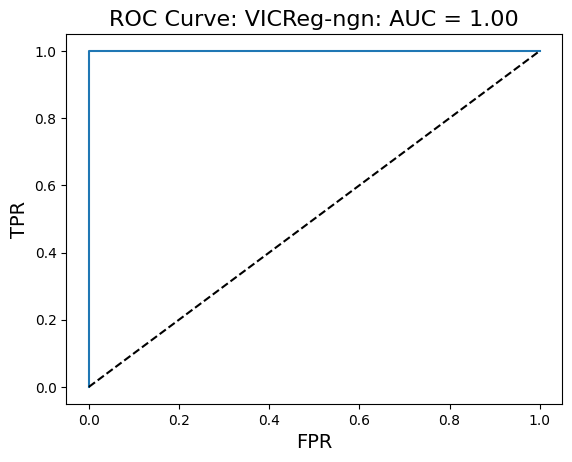

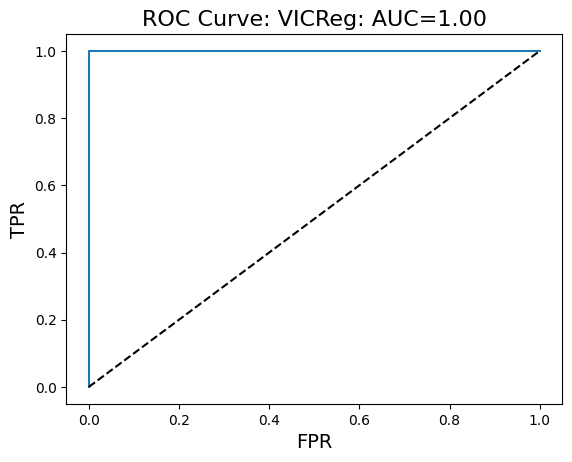

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_true, y_scores, title):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')

    plt.xlabel('FPR', fontsize=14)
    plt.ylabel('TPR', fontsize=14)
    plt.title(title, fontsize=16)

plot_roc(testset.labels, score_ngn, 'ROC Curve: VICReg-ngn: AUC = 1.00')
plot_roc(testset.labels, score_vic, 'ROC Curve: VICReg: AUC=1.00')
plt.show()

**Qualitative EvaluationAmbiguity of Anomaly Detection**

 We plot the 7 most anomalous samples according to VICReg and VICReg without the generate neighbors. Explain what aspects each method found to be anomalous.

 **Results:**

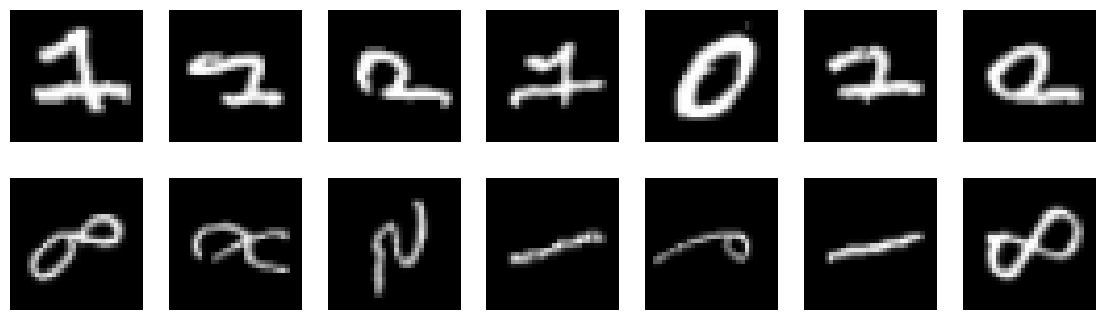

In [ ]:
_, top_indices1 = torch.topk(torch.tensor(score_vic), 7)
_, top_indices2 = torch.topk(torch.tensor(score_ngn), 7)

to_plot = torch.stack([top_indices1, top_indices2])
fig, axs = plt.subplots(2, 7, figsize=(14, 4))
methods = ['VICReg', 'VICReg-ngn']

for i in range(2):
    axs[i, 0].set_ylabel(methods[i], fontsize=14)
    for j in range(7):
        img = testset.data[to_plot[i, j]]
        axs[i, j].imshow(img.T)
        axs[i, j].axis('off')
        axs[i, j].set_frame_on(False)

plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()
